In [78]:
# Importing needed files
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from datetime import datetime
import matplotlib.image as mpimg
import pickle
%matplotlib inline



In [25]:
class Camera_Calibration:
    def __init__(self):
        self.calib_images_loaded = True
        # Arrays to store object points and image points from all the images.
        self.obj_points = []  # 3d points in real world space
        self.img_points = []  # 2d points in image plane.
        self.ret = 0  # RMS re projection error. Should be between 0.1 and 1 pixel. An RMS error of 1.0 means that, on average, each of these projected points is 1.0 px away from its actual position. The error is not bounded in [0, 1], it can be considered as a distance.
        self.mtx = 0  # Camera calibration matrix
        self.dist = 0  # Distortion coefficient
        self.rvecs = 0  # Rotation Vector
        self.tvecs = 0  # Translation Vector
        self.nx = 9
        self.ny = 6

    def __find_points(self):
        """
        Function to get object points and image points using the chessboard images
        :return:
        """
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((self.ny * self.nx, 3), np.float32)
        objp[:, :2] = np.mgrid[0:self.nx, 0:self.ny].T.reshape(-1, 2)  # X, Y coordinates

        # Make a list of calibration images
        images = glob.glob('camera_cal/calibration*.jpg')
        fig, axs = plt.subplots(5,4, figsize=(16, 11))
        fig.subplots_adjust(hspace = .2, wspace=.001)
        axs = axs.ravel()

        # Step through the list and search for chessboard corners
        for i, fname in enumerate(images):
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (self.nx, self.ny), None)

            # If found, add object points, image points
            if ret == True:
                self.obj_points .append(objp)
                self.img_points .append(corners)

                # Draw and display the corners
                img = cv2.drawChessboardCorners(img, (self.nx,self.ny), corners, ret)
                axs[i].axis('off')
                axs[i].imshow(img)
        plt.show()
        self.__save_points()

    def __find_point(self, img,nx, ny):
        """
        Finds image and object points in single image
        :param img: input image
        :param nx: number of inner corners in each row
        :param ny: number of inner corners in each column
        :return:
        """
        self.nx = nx
        self.ny = ny
        self.obj_points.clear()
        self.img_points.clear()
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((self.ny * self.nx, 3), np.float32)
        objp[:, :2] = np.mgrid[0:self.nx, 0:self.ny].T.reshape(-1, 2)  # X, Y coordinates
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (self.nx, self.ny), None)
        # If found, add object points, image points
        if ret == True:
            self.obj_points .append(objp)
            self.img_points .append(corners)
            # Draw and display the corners
            #img = cv2.drawChessboardCorners(img, (self.nx,self.ny), corners, ret)

    def __save_points(self):
        """
        This function saves the image points and object points to use them later
        instead of computing every time
        :return:
        """
        file_Name = "imgpoints"
        # open the file for writing
        fileObject = open(file_Name, 'wb')
        pickle.dump(self.img_points, fileObject)
        # close the fileObject
        fileObject.close()
        file_Name = "objpoints"
        # open the file for writing
        fileObject = open(file_Name, 'wb')
        # this writes the object a to the
        pickle.dump(self.obj_points, fileObject)
        # close the fileObject
        fileObject.close()

    def calibrate_camera(self,img, nx, ny, load_saved_points = True):
        """
        Performs the camera calibration
        :param img: input image
        :return:
        """
        img_size = (img.shape[1], img.shape[0])
        if load_saved_points:
            if self.calib_images_loaded:
                # load already saved object points and image points
                self.obj_points = pickle.load( open( "objpoints", "rb" ) )
                self.img_points = pickle.load( open( "imgpoints", "rb" ) )
                # Do camera calibration given object points and image points
                self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(self.obj_points,
                                                                        self.img_points, img_size,None,None)
            else:
                self.__find_points()
                # Do camera calibration given object points and image points
                self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(self.obj_points,
                                                                        self.img_points, img_size,None,None)

        else:
            self.__find_point(img,nx,ny)
            # Do camera calibration given object points and image points
            self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(self.obj_points,
                                                                    self.img_points, img_size,None,None)


In [27]:
class Gradient_Color_Space:

    def __mag_dir_thresh(self,img, sobel_kernel=3):
        """
        Computes the overall magnitude of the gradient
        :param img: input image
        :param sobel_kernel: kernel size
        :return: gradient image
        """
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255
        gradmag = (gradmag/scale_factor).astype(np.uint8)
        # Take the absolute value of the gradient direction
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = self.__apply_threshold(gradmag,absgraddir)

        # Return the binary image
        return binary_output

    def __apply_threshold(self,gradient_img,grad_dir):
        """
        Function to find the gradient thresholds automatically
        :param gradient_img:
        :return: Gradient thresholded binary image
        """
        hist = cv2.calcHist([gradient_img],[0],None,[16],[0,256])
        lower_med = np.median(hist[:7])
        lower_med_idx = np.where(hist == lower_med)
        lower_thershold = lower_med_idx[0][0] * 15  # Multiplying by 15 since we we have 16 total bins

        upper_med = np.median(hist[7:])
        upper_med_idx = np.where(hist == upper_med)
        upper_thershold = upper_med_idx[0][0] * 15 # Multiplying by 15 since we we have 16 total bins

        binary_output = np.zeros_like(gradient_img)
        binary_output[(gradient_img >= lower_thershold) & (gradient_img <= upper_thershold) &
                      (grad_dir <= 1.3) & (grad_dir >= 0.3)] = 1
        return binary_output

    def __hls_select(self,img, thresh=(0, 255)):
        """
        Function to get binary image of S channel of input image
        :param img: input RGB image
        :param thresh: Thresholds for S channel
        :return: binary image of S channel
        """
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        binary_output = np.zeros_like(s_channel)
        binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
        return binary_output

    def grad_clr_threshold(self,img):
        """
        Function to find gradient and color threshold of an input image
        :param img: input RGB image
        :return: color binary image and combined gradient and color thresholded image
        """
        s_binary = self.__hls_select(img.copy(),thresh=(100,255))
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        l_channel = hls[:,:,1]
        grad_binary = self.__mag_dir_thresh(l_channel.copy(),5)
        # Stack each channel
        # The green is the gradient threshold component and blue is the color channel threshold component
        color_binary = np.dstack((np.zeros_like(grad_binary), grad_binary, s_binary)) * 255
        # Combine the two binary thresholds
        combined_binary = np.zeros_like(grad_binary)
        combined_binary[(s_binary == 1) | (grad_binary == 1)] = 1
        return color_binary,combined_binary   


In [28]:
class Transform_Image:
    def __init__(self):
        self.src = []  # source points for transform
        self.dst = [] # destination points for transform
        self.M = 0 # Perspective Transform Matrix
        self.invM = 0 # Inverse Perspective Transform Matrix
        self.points_loaded = False

    def undistort(self, img, mtx, dist):
        """
        Corrects image distortion using calibration matrices
        :param img:
        :return:
        """
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        return undist

    def warp_image(self,bin_thresholded_img,undist_img):
        """
        Warps the input image
        :param threshold_img:Gradient and Color Thresholded image
        :return:warped image
        """
        if not self.points_loaded:
        # define source and destination points for transform
            bottomY = 672 # originally it was set to 720
            topY = 440

            bottom_left = (190, bottomY) # bottom_left
            top_left = (585, topY)
            top_right = (705, topY)
            bottom_right = (1130, bottomY)

            # top left -> top right -> bottom left -> bottom right
            src = np.float32([
                top_left,
                top_right,
                bottom_right,
                bottom_left
            ])
            nX = undist_img.shape[1]
            nY = undist_img.shape[0]
            img_size = (nX, nY)
            offset = 200
            dst = np.float32([
                [offset, 0],
                [img_size[0] - offset, 0],
                [img_size[0] - offset, img_size[1]],
                [offset, img_size[1]]
            ])
            self.src = src
            self.dst = dst
            self.points_loaded = True

        img_size = (bin_thresholded_img.shape[1], bin_thresholded_img.shape[0])
        # Given src and dst points, calculate the perspective transform matrix
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        # Warp the image using OpenCV warpPerspective()
        bin_warped = cv2.warpPerspective(bin_thresholded_img, self.M, img_size)

        color_warped = cv2.warpPerspective(undist_img, self.M, img_size)
        self.invM = cv2.getPerspectiveTransform(self.dst, self.src)

        return bin_warped,color_warped

In [29]:
class Find_Lane_Lines:
    def __init__(self):
        self.left_line_x_coord = [] # x coordinates of left lane line
        self.left_line_y_coord = [] # y coordinates of left lane line
        self.right_line_x_coord = [] # x coordinates of right lane line
        self.right_line_y_coord = [] # y coordinates of right lane line
        self.first_image = True  # Flag to run sliding window only once
        self.left_poly_coeffs = [] # Coefficients of left line polynomial
        self.right_poly_coeffs = [] # Coefficients of right line polynomial
        self.points_y = [] # Points to draw overlays
        self.ym_per_pix = 3.048/100 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/278 # meters per pixel in x dimension
        self.debug = False # Flag to get additional output for debugging


    def __find_lane_pixels(self,bin_warped_img,col_warped_img = None):
        """
        Function to find pixels which belongs to left and right lane lines
        :param bin_warped_img:binary input warped image
        :return:
        """
        viz_img = np.dstack((bin_warped_img, bin_warped_img, bin_warped_img))
        if self.debug:
            viz_img = np.copy(col_warped_img)

        # Eliminate not interested region
        bin_warped_img[:, 0:150] = 0
        bin_warped_img[:, 1200:] = 0
        bin_warped_img[0:200, :] = 0

        # Take a histogram of the bottom half of the image
        hist = np.sum(bin_warped_img[:bin_warped_img.shape[0], :], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        mid = np.int(hist.shape[0] // 2)
        left_x_base = np.argmax(hist[:mid])
        right_x_base = np.argmax(hist[mid:]) + mid
        n_windows = 9 # Number of sliding windows
        margin = 150 # Width of the window
        min_px = 25 # Minimum number of pixels to recenter the window
        w_ht = np.int(bin_warped_img.shape[0] // n_windows) # set height of window based upon number of windows
                                                          # and image height
        # Identify the x and y positions of all nonzero pixels in the image
        non_zero = bin_warped_img.nonzero()
        non_zero_y = np.array(non_zero[0])
        non_zero_x = np.array(non_zero[1])

        # Current positions to be updated later for each window in nwindows
        left_x_current = left_x_base
        right_x_current = right_x_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        # Step through the windows one by one
        for window in range(n_windows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = bin_warped_img.shape[0] - (window + 1) * w_ht
                win_y_high = bin_warped_img.shape[0] - window * w_ht
                win_xleft_low = left_x_current - margin
                win_xleft_high = left_x_current + margin
                win_xright_low = right_x_current - margin
                win_xright_high = right_x_current + margin

                if self.debug:
                    # Draw the windows on the visualization image
                    cv2.rectangle(viz_img, (win_xleft_low, win_y_low),
                                  (win_xleft_high, win_y_high), (0, 255, 0), 4)
                    cv2.rectangle(viz_img, (win_xright_low, win_y_low),
                                  (win_xright_high, win_y_high), (0, 255, 0), 4)

                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((non_zero_y >= win_y_low) & (non_zero_y < win_y_high) &
                                  (non_zero_x >= win_xleft_low) & (non_zero_x < win_xleft_high)).nonzero()[0]
                good_right_inds = ((non_zero_y >= win_y_low) & (non_zero_y < win_y_high) &
                                   (non_zero_x >= win_xright_low) & (non_zero_x < win_xright_high)).nonzero()[0]

                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)

                # If we find pixels more than min_px, recenter next window on its mean position
                if len(good_left_inds) > min_px:
                    left_x_current = np.int(np.mean(non_zero_x[good_left_inds]))
                if len(good_right_inds) > min_px:
                    right_x_current = np.int(np.mean(non_zero_x[good_right_inds]))
        # Concatenate the arrays of indices
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Do nothing
            pass
        # Extract left and right line pixel positions
        self.left_line_x_coord = non_zero_x[left_lane_inds]
        self.left_line_y_coord = non_zero_y[left_lane_inds]
        self.right_line_x_coord = non_zero_x[right_lane_inds]
        self.right_line_y_coord = non_zero_y[right_lane_inds]

        if self.debug:
            return viz_img

    def fit_polynomial(self,Minv,bin_warped_img,undist_img,col_warped_img = None):
        """
        Fits the polynomial on the left and right lane line coordinates
        :param bin_warped_img: binary warped image
        :param undist_img: original undistorted image
        :param Minv: inverse M matrix to dewarp image
        :param col_warped_img: warped color image
        :return: weighted warped color image with overlays
        """
        # find lane pixels first
        if self.debug:
            sliding_window_img = self.__find_lane_pixels(bin_warped_img,col_warped_img)
        else:
            _ = self.__find_lane_pixels(bin_warped_img)

        # fit a second order polynomial
        self.left_poly_coeffs = np.polyfit(self.left_line_y_coord,self.left_line_x_coord,2)
        self.right_poly_coeffs = np.polyfit(self.right_line_y_coord,self.right_line_x_coord,2)

        # Generate points for drawing
        self.points_y = np.linspace(0, bin_warped_img.shape[0] - 1, bin_warped_img.shape[0])
        # find all x points between two lane lines
        try:
            left_fit_x = self.left_poly_coeffs[0] * self.points_y ** 2 + self.left_poly_coeffs[1] * self.points_y + self.left_poly_coeffs[2]
            right_fit_x = self.right_poly_coeffs[0] * self.points_y ** 2 + self.right_poly_coeffs[1] * self.points_y + self.right_poly_coeffs[2]
        except:
            print('Failed to fit a line!')
            left_fit_x = 1 * self.points_y ** 2 + 1 * self.points_y
            right_fit_x = 1 * self.points_y ** 2 + 1 * self.points_y

        # Create an image to draw the lines on
        warp_zero_img = np.zeros_like(bin_warped_img).astype(np.uint8)
        color_warp_img = np.dstack((warp_zero_img, warp_zero_img, warp_zero_img))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fit_x, self.points_y]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit_x, self.points_y])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp_img, np.int_([pts]), (0, 255, 0))
        cv2.polylines(color_warp_img, np.int32([pts_left]), isClosed=False, color=(255, 0, 0), thickness=15)
        cv2.polylines(color_warp_img, np.int32([pts_right]), isClosed=False, color=(255, 0, 0), thickness=15)

        final_warped_img = cv2.warpPerspective(color_warp_img, Minv, (undist_img.shape[1], undist_img.shape[0]))
        # Combine the result with the original image
        final_warped_img = cv2.addWeighted(undist_img, 1, final_warped_img, 0.6, 0)
        left_curverad, right_curverad, center_dist = self.__calculate_radius_of_curvature(bin_warped_img)
        final_warped_img = self.__draw_data(final_warped_img,left_curverad, right_curverad, center_dist)

        if self.debug:
            return sliding_window_img,final_warped_img

        self.first_image = False
        return final_warped_img

    def search_around_poly(self,Minv,bin_warped_img,undist_img):
        """
        Function to search lane lines pixels around already found lane lines
        :param Minv: inverse M matrix to dewarp image
        :param bin_warped_img:binary warped image
        :param undist_img:original undistorted image
        :return:weighted warped color image with overlays
        """

        margin = 50
        # Grab activated pixels
        non_zero = bin_warped_img.nonzero()
        non_zero_y = np.array(non_zero[0])
        non_zero_x = np.array(non_zero[1])

        #Set the area of search based on activated x-values
        left_lane_inds = ((non_zero_x > (self.left_poly_coeffs[0] * (non_zero_y ** 2) + self.left_poly_coeffs[1] * non_zero_y +
                                         self.left_poly_coeffs[2] - margin)) & (non_zero_x < (self.left_poly_coeffs[0] * (non_zero_y ** 2) +
                                         self.left_poly_coeffs[1] * non_zero_y + self.left_poly_coeffs[2] + margin)))

        right_lane_inds = ((non_zero_x > (self.right_poly_coeffs[0] * (non_zero_y ** 2) + self.right_poly_coeffs[1] * non_zero_y +
                                          self.right_poly_coeffs[2] - margin)) & (non_zero_x < (self.right_poly_coeffs[0] * (non_zero_y ** 2) +
                                          self.right_poly_coeffs[1] * non_zero_y + self.right_poly_coeffs[2] + margin)))

        # Again, extract left and right line pixel positions
        self.left_line_x_coord = non_zero_x[left_lane_inds]
        self.left_line_y_coord = non_zero_y[left_lane_inds]
        self.right_line_x_coord = non_zero_x[right_lane_inds]
        self.right_line_y_coord = non_zero_y[right_lane_inds]

        # Fit new polynomials
        left_fit_x, right_fit_x, points_y = self.fit_poly(bin_warped_img.shape, self.left_line_x_coord, self.left_line_y_coord,
                                                     self.right_line_x_coord, self.right_line_y_coord)

        # Create image to draw overlay on
        viz_img = np.dstack((bin_warped_img, bin_warped_img, bin_warped_img)) * 255
        window_img = np.zeros_like(viz_img)
        # Color in left and right line pixels
        window_img[non_zero_y[left_lane_inds], non_zero_x[left_lane_inds]] = [255, 0, 0]
        window_img[non_zero_y[right_lane_inds], non_zero_x[right_lane_inds]] = [255, 0, 0]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fit_x - margin, points_y]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fit_x + margin,
                                                                        points_y])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))

        right_line_window1 = np.array([np.transpose(np.vstack([right_fit_x - margin, points_y]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fit_x + margin,
                                                                         points_y])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        if self.debug:
            cv2.fillPoly(viz_img, np.int_([left_line_pts]), (0, 255, 0))
            cv2.fillPoly(viz_img, np.int_([right_line_pts]), (0, 255, 0))
            result = cv2.addWeighted(viz_img, 1, window_img, 0.3, 0)

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(bin_warped_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fit_x, points_y]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit_x, points_y])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
        cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255, 0, 0), thickness=15)
        cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(255, 0, 0), thickness=15)
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (undist_img.shape[1], undist_img.shape[0]))
        # Combine the result with the original image
        final_img = cv2.addWeighted(undist_img, 1, newwarp, 0.6, 0)

        left_curverad, right_curverad, center_dist = self.__calculate_radius_of_curvature(bin_warped_img)
        final_img = self.__draw_data(final_img,left_curverad, right_curverad, center_dist)

        if self.debug:
            return result,final_img

        return final_img

    def fit_poly(self,img_shape,left_x,left_y,right_x,right_y):
        """
        Fits the polynomial on the x and y coordinates of the lane lines
        :param img_shape:shape of input image
        :param left_x:x coordinates of left line points
        :param left_y:y coordinates of left line points
        :param right_x:x coordinate of right line points
        :param right_y:y coordinates of right line points
        :return:points between left and right lane lines
        """
        ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
        self.left_poly_coeffs = np.polyfit(left_y , left_x , 2)
        self.right_poly_coeffs = np.polyfit(right_y , right_x , 2)
        # Generate x and y values for plotting
        #ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
        ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
        left_fitx = self.left_poly_coeffs[0] * self.points_y ** 2 + self.left_poly_coeffs [1] * self.points_y + self.left_poly_coeffs [2]
        right_fitx = self.right_poly_coeffs[0] * self.points_y  ** 2 + self.right_poly_coeffs[1] * self.points_y  + self.right_poly_coeffs[2]

        return left_fitx, right_fitx, self.points_y

    def __calculate_radius_of_curvature(self,bin_warped_img):
        """
        Calculates the radius of curvature and center distance
        :param bin_warped_img:input binary warped image
        :return:left, right curvature radii and center distance
        """
        ht = bin_warped_img.shape[0]
        # choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(self.points_y)

        if len(self.left_line_x_coord) != 0 and len(self.right_line_x_coord) != 0:
            # Fit new polynomials to x,y in world space
            left_fit_cr = np.polyfit(self.left_line_y_coord * self.ym_per_pix, self.left_line_x_coord * self.xm_per_pix, 2)
            right_fit_cr = np.polyfit(self.right_line_y_coord * self.ym_per_pix, self.right_line_x_coord * self.xm_per_pix, 2)

        # Calculation of R_curve (radius of curvature)
        left_curve_rad = ((1 + (2 * left_fit_cr[0] * y_eval * self.ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
            2 * left_fit_cr[0])
        right_curve_rad = ((1 + (2 * right_fit_cr[0] * y_eval * self.ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
            2 * right_fit_cr[0])

        # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts
        if self.right_poly_coeffs is not None and self.left_poly_coeffs  is not None:
            car_position = bin_warped_img.shape[1]/2
            l_fit_x_int = self.left_poly_coeffs [0]*ht**2 + self.left_poly_coeffs [1]*ht + self.left_poly_coeffs [2]
            r_fit_x_int = self.right_poly_coeffs[0]*ht**2 + self.right_poly_coeffs[1]*ht + self.right_poly_coeffs[2]
            lane_center_position = (r_fit_x_int + l_fit_x_int) /2
            center_dist = (car_position - lane_center_position) * self.xm_per_pix

        return left_curve_rad, right_curve_rad, center_dist

    def __draw_data(self,final_img, left_curve_rad,right_curve_rad , center_dist):
        """
        draws text on final image
        :param final_img: input final image
        :param left_curve_rad: left line radius of curvature
        :param right_curve_rad: right line radius of curvature
        :param center_dist: center distance
        :return: 
        """
        new_img = np.copy(final_img)
        font = cv2.FONT_HERSHEY_DUPLEX
        text_left = 'Left Curvature: ' + '{:04.2f}'.format(left_curve_rad) + 'm'
        text_right = 'Right Curvature: ' + '{:04.2f}'.format(right_curve_rad) + 'm'
        cv2.putText(new_img, text_left, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
        cv2.putText(new_img, text_right, (40, 120), font, 1.5, (200, 255, 155), 2, cv2.LINE_AA)
        direction = ''
        if center_dist > 0:
            direction = 'right'
        elif center_dist < 0:
            direction = 'left'
        abs_center_dist = abs(center_dist)
        text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
        cv2.putText(new_img, text, (40,190), font, 1.5, (200,255,155), 2, cv2.LINE_AA)

        return new_img




In [31]:
class AdvanceLaneLines:
    def __init__(self):
        """
        Instantiate required objects
        """
        self.cc = Camera_Calibration()
        self.ti = Transform_Image()
        self.gcs = Gradient_Color_Space()
        self.fll = Find_Lane_Lines()
        self.calibration_finished = False

    def covert_img(self,img):
        """
        convert input BGR image to RGB
        :param img: input BGR image
        :return: RGB image
        """
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    def calibrate_camera(self,img):
        """
        Function to calibrate camera
        :param img: known input image
        :return:
        """
        self.cc.calibrate_camera(img,8,6,load_saved_points=True)

    def correct_distortion(self,img):
        """
        Corrects the distortion of an input image using camera calibration matrices
        :param img: distorted input image
        :return: undistorted image
        """
        undist_img = self.ti.undistort(img,self.cc.mtx,self.cc.dist)
        return undist_img


    def transform_image(self, bin_thresholded_img,undist_img):
        """
        Transforms image by doing Perspective Transformation
        :param img: undistorted input image
        :return: warped image
        """
        bin_warped,color_warped = self.ti.warp_image(bin_thresholded_img,undist_img)
        return bin_warped,color_warped

    def color_gradient_threshold(self,img):
        """
        Function to perform thresholding on input image based upon gradient
        and color space
        :param img: input image
        :return: thresholded images
        """
        clr_binary, cmb_binary = self.gcs.grad_clr_threshold(img)
        return cmb_binary

    def find_lane_lines(self,bin_warped_img,undist_img,col_warped_img = None):
        if self.fll.debug:
           if self.fll.first_image:
               sliding_window_img,final_warped_img = self.fll.fit_polynomial(self.ti.invM,bin_warped_img,undist_img,col_warped_img)
               return sliding_window_img,final_warped_img
           else:
               col_warped_img,final_warped_img = self.fll.search_around_poly(self.ti.invM,bin_warped_img,undist_img)
               return col_warped_img,final_warped_img
        else:
            if self.fll.first_image:
                final_warped_img = self.fll.fit_polynomial(self.ti.invM,bin_warped_img,undist_img,col_warped_img)
                return final_warped_img
            else:
                final_warped_img = self.fll.search_around_poly(self.ti.invM,bin_warped_img,undist_img)
                return final_warped_img


In [63]:
def process_video_images(img,adv_ll):
    """
    Helper function to process video images through pipeline
    :param img: input image
    :param adv_ll: AdvanceLaneLines object
    :return: output image with lane lines overlays
    """
    img = adv_ll.covert_img(img)
    if not adv_ll.calibration_finished:
        adv_ll.calibrate_camera(img)
        adv_ll.calibration_finished = True

    undist_img = adv_ll.correct_distortion(img)
    bin_thresholded_img = adv_ll.color_gradient_threshold(undist_img)
    bin_warped_img,color_warped_img = adv_ll.transform_image(bin_thresholded_img,undist_img)
    final_img = adv_ll.find_lane_lines(bin_warped_img,undist_img,color_warped_img)
    final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
    return final_img

def process_test_images(adv_ll):
    """
    Function to process test images through pipeline
    :param adv_ll: AdvanceLaneLines object
    :return:
    """
    for filename in os.listdir("test_images/"):
        img = cv2.imread(os.path.join("test_images/", filename))
        if img is not None:
            print(filename)
            adv_ll.fll.first_image = True
            adv_ll.fll.debug = True
            img = adv_ll.covert_img(img)
            if not adv_ll.calibration_finished:
                adv_ll.calibrate_camera(img.copy())
                adv_ll.calibration_finished = True

            undist_img = adv_ll.correct_distortion(img.copy())
            bin_thresholded_img = adv_ll.color_gradient_threshold(undist_img.copy())
            bin_warped_img,color_warped_img = adv_ll.transform_image(bin_thresholded_img,undist_img.copy())
            sliding_window_img,final_img = adv_ll.find_lane_lines(bin_warped_img.copy(),undist_img.copy(),color_warped_img.copy())

            fig, axs = plt.subplots(2, 4,figsize=(30,15))
            axs[0, 0].imshow(img)
            axs[0, 0].axis('off')
            axs[0, 0].set_title("Original Image:{}".format(filename))

            axs[0, 1].imshow(undist_img)
            axs[0, 1].axis('off')
            axs[0, 1].set_title("Undistorted Image:{}".format(filename))  

            axs[0, 2].imshow(bin_thresholded_img,cmap='gray')
            axs[0, 2].axis('off')
            axs[0, 2].set_title("Binary Thresholded Image:{}".format(filename))                        

            axs[0, 3].imshow(bin_warped_img,cmap='gray')
            axs[0, 3].axis('off')
            axs[0, 3].set_title("Binary Warped Image:{}".format(filename))            

            axs[1, 0].imshow(color_warped_img)
            axs[1, 0].axis('off')
            axs[1, 0].set_title("Color Warped Image:{}".format(filename))

            axs[1, 1].imshow(sliding_window_img)
            axs[1, 1].axis('off')
            axs[1, 1].set_title("Sliding Window Image{}".format(filename))

            axs[1, 2].imshow(final_img)
            axs[1, 2].axis('off')
            axs[1, 2].set_title("Final De-warped Image:{}".format(filename))

            fig.delaxes(axs[1][3])            
            plt.subplots_adjust(wspace=0, hspace=0)
            plt.show()

In [74]:
def main():
    test_images = True
    adv_ll = AdvanceLaneLines()

    if test_images:
        process_test_images(adv_ll)
    else:
        project_video_out = 'output_images/project_video.mp4'
        clip1 = VideoFileClip("project_video.mp4")
        project_video_out_clip = clip1.fl_image(lambda image:process_video_images(image, adv_ll))  # NOTE: this function expects color images!!
        project_video_out_clip.write_videofile(project_video_out, audio=False)

test2.jpg


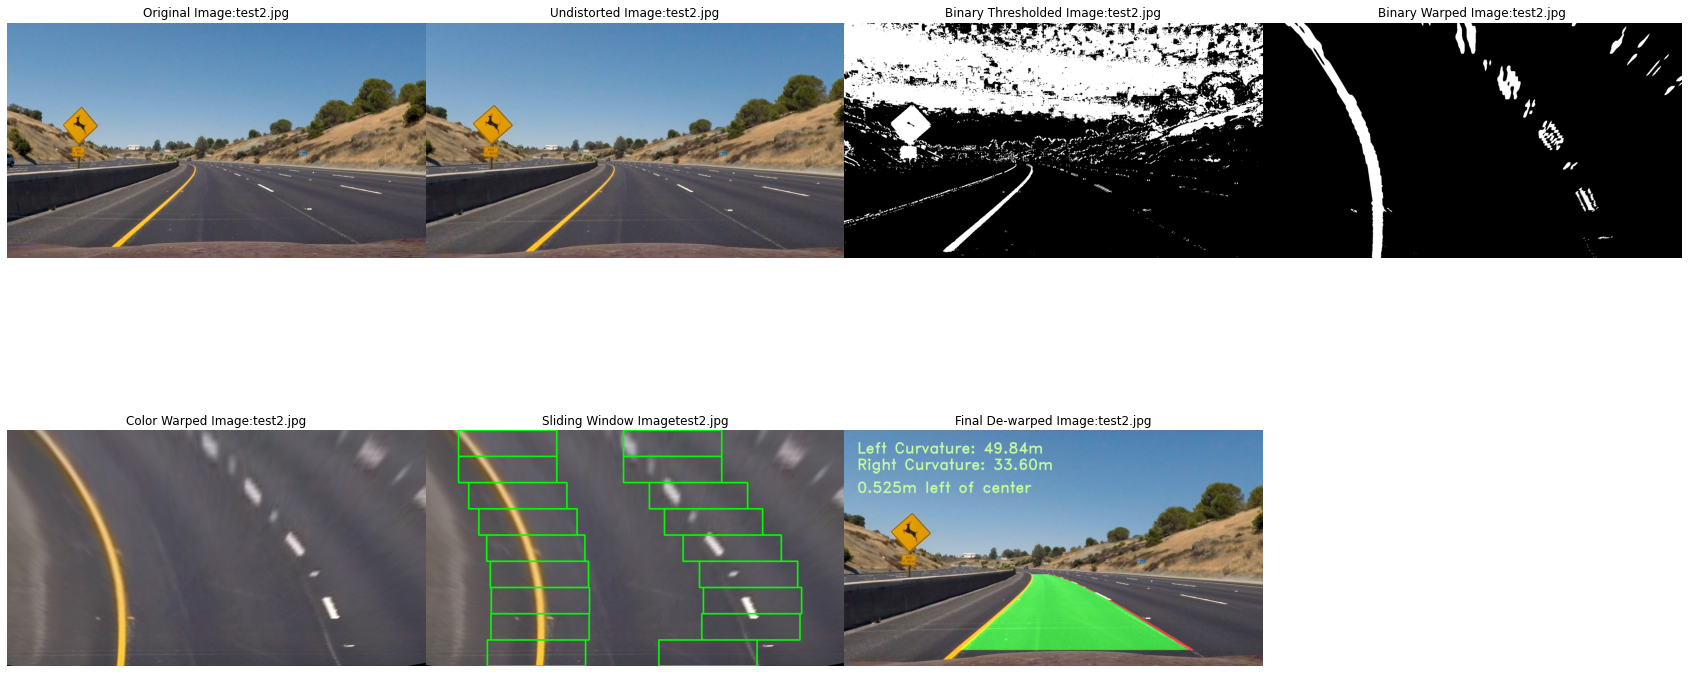

test3.jpg


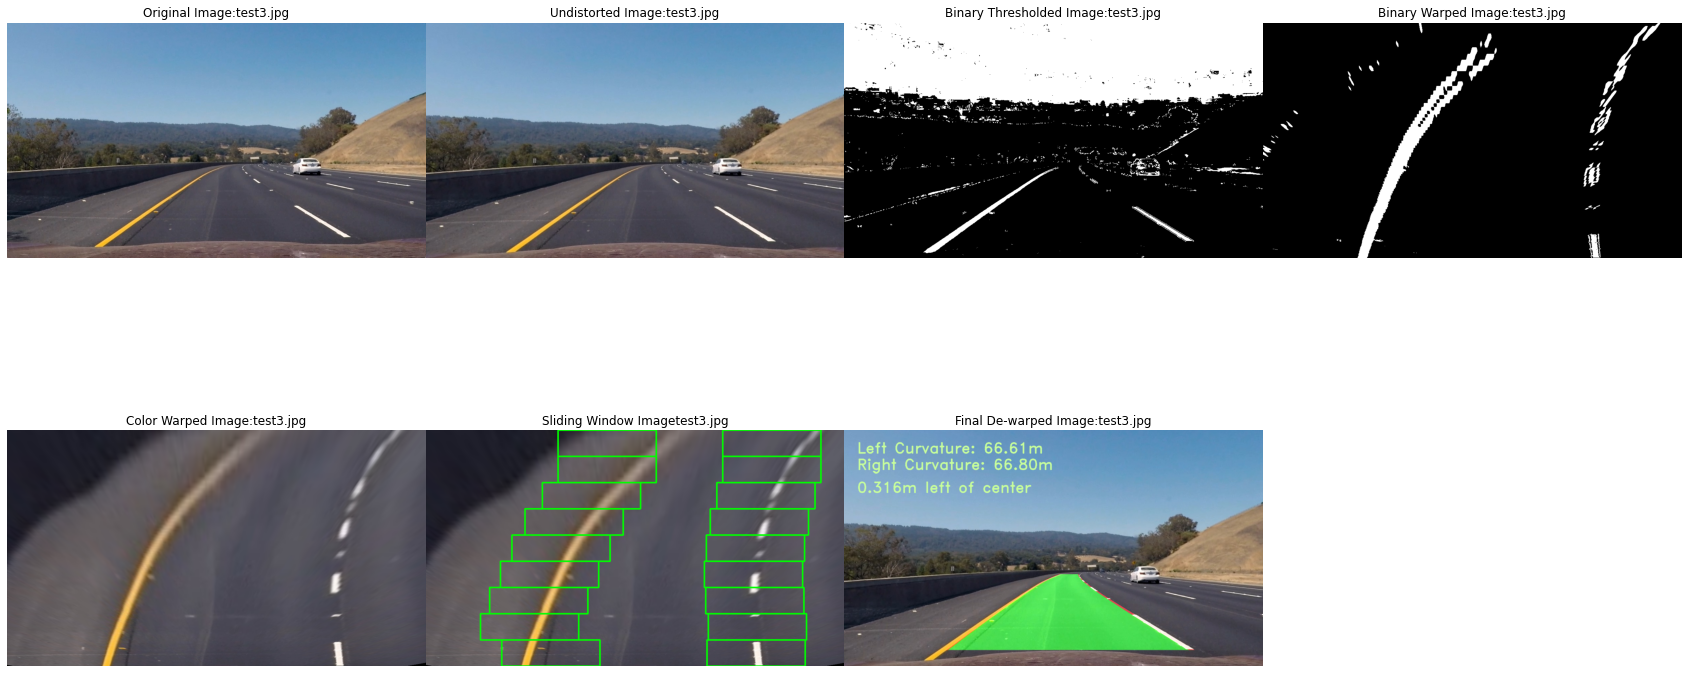

test6.jpg


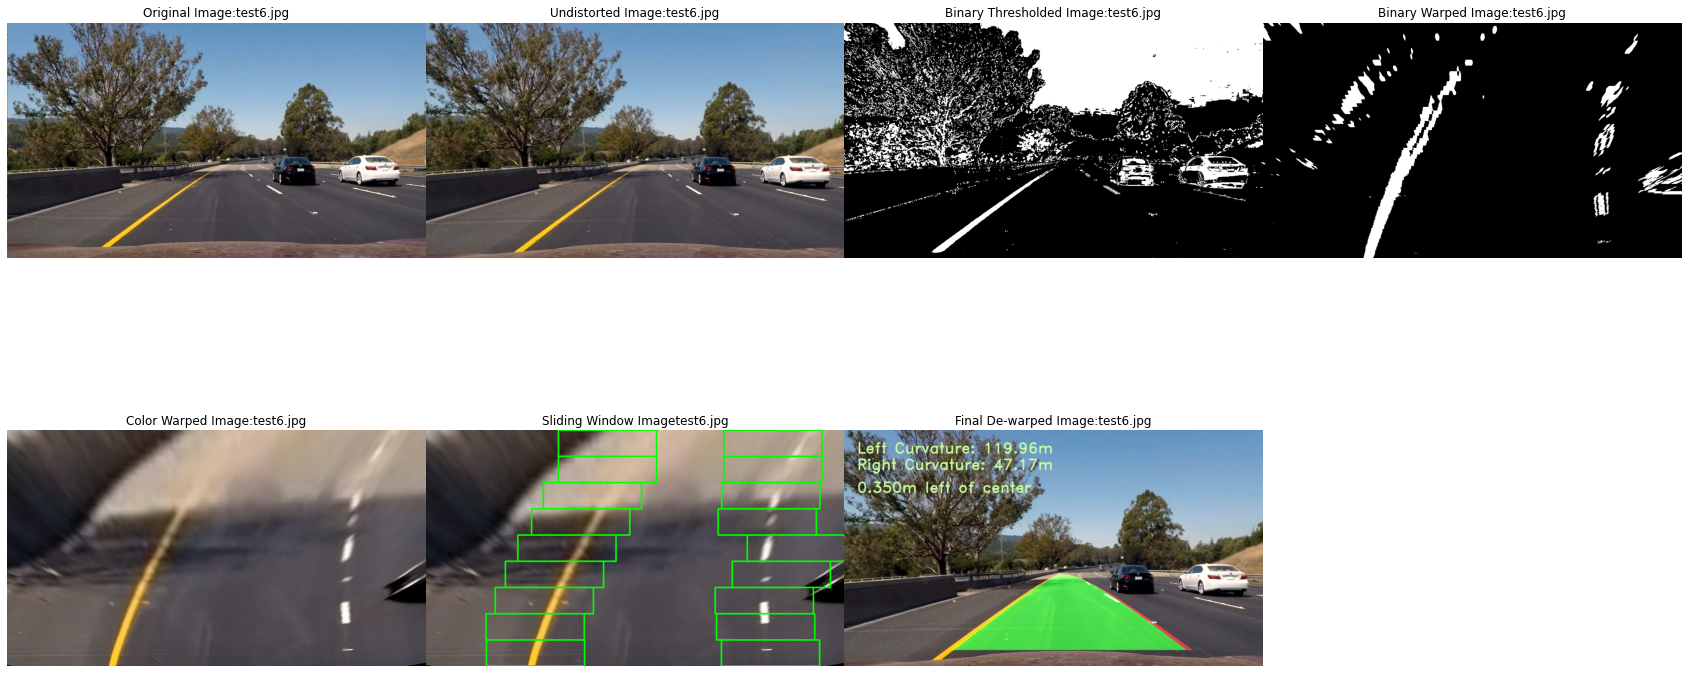

test4.jpg


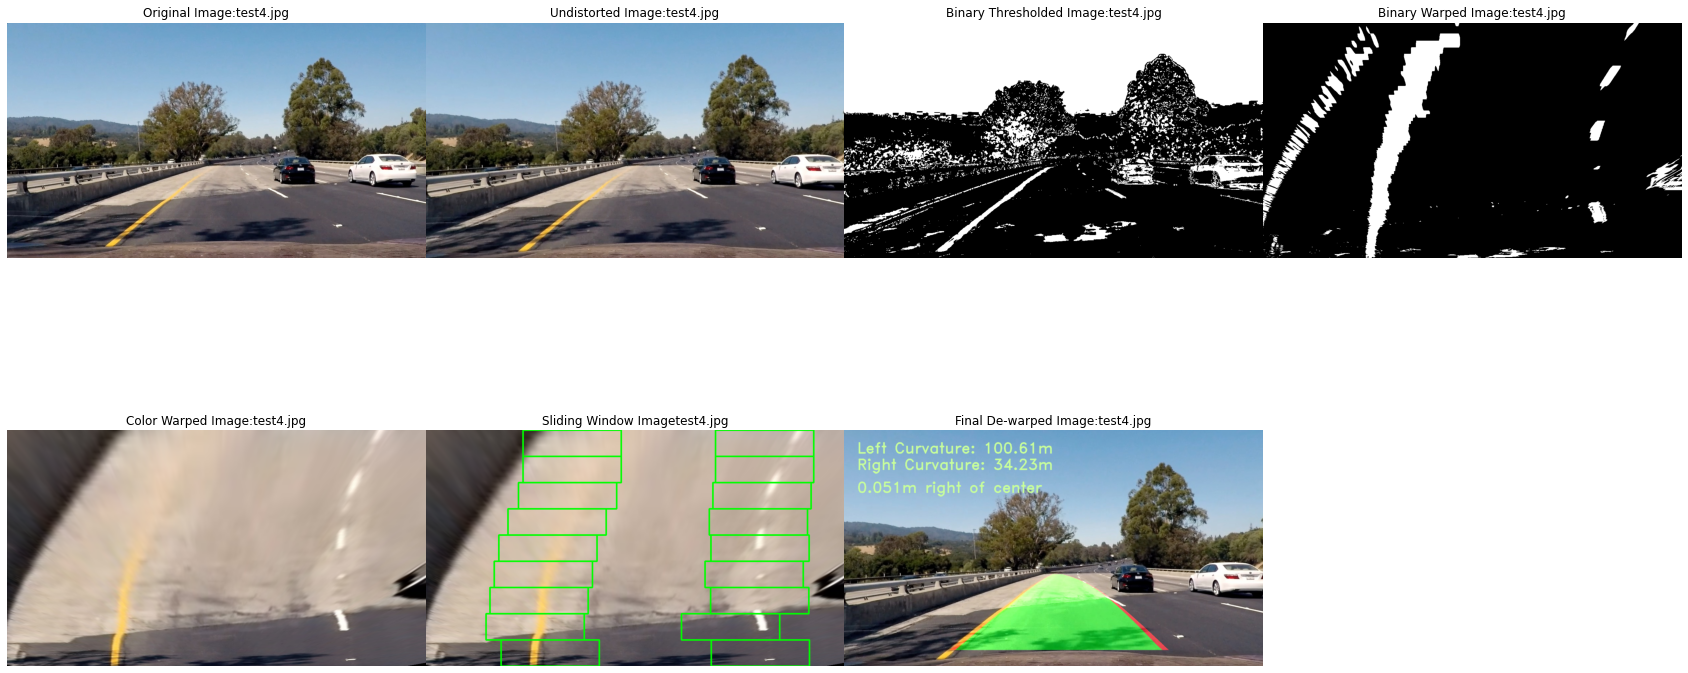

straight_lines1.jpg


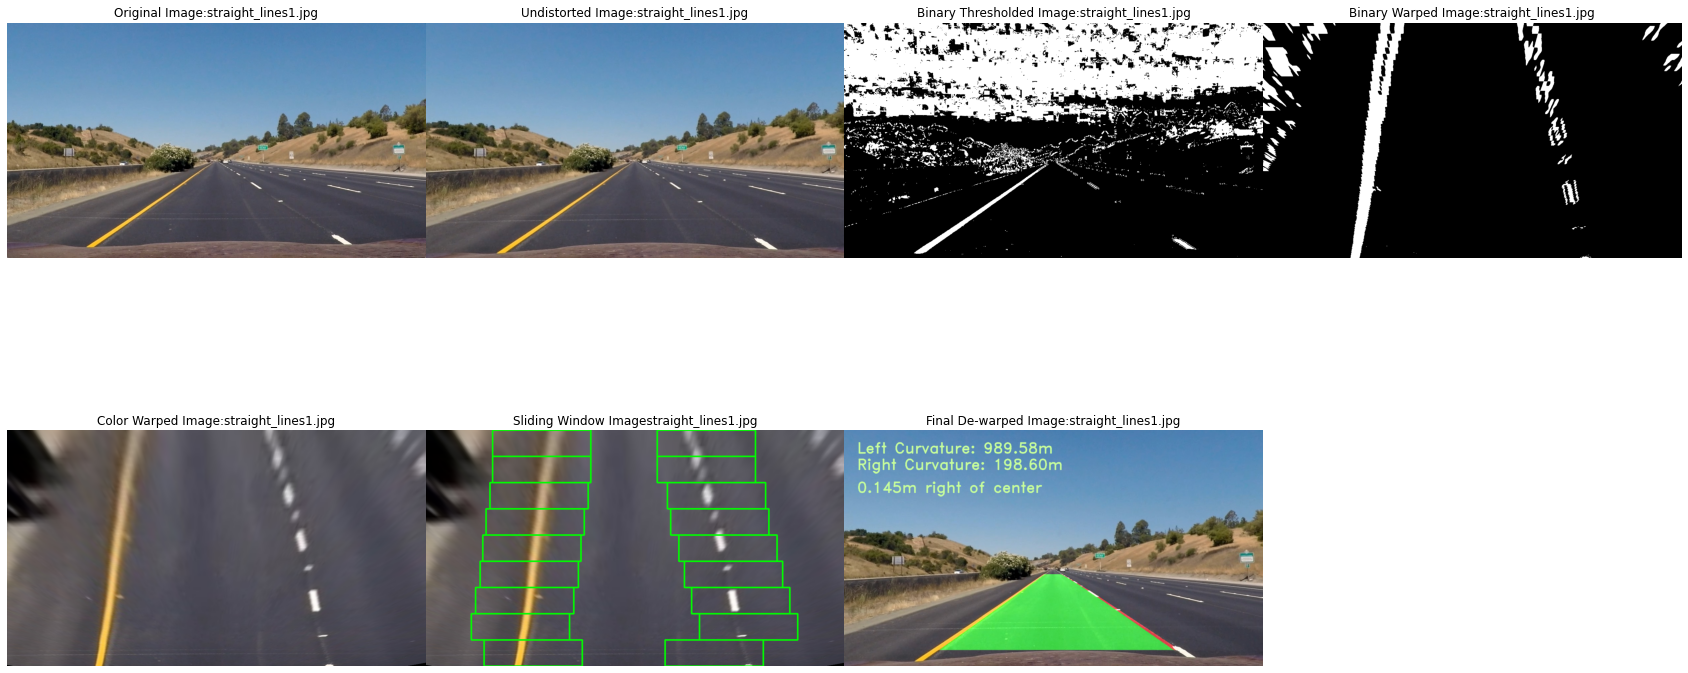

straight_lines2.jpg


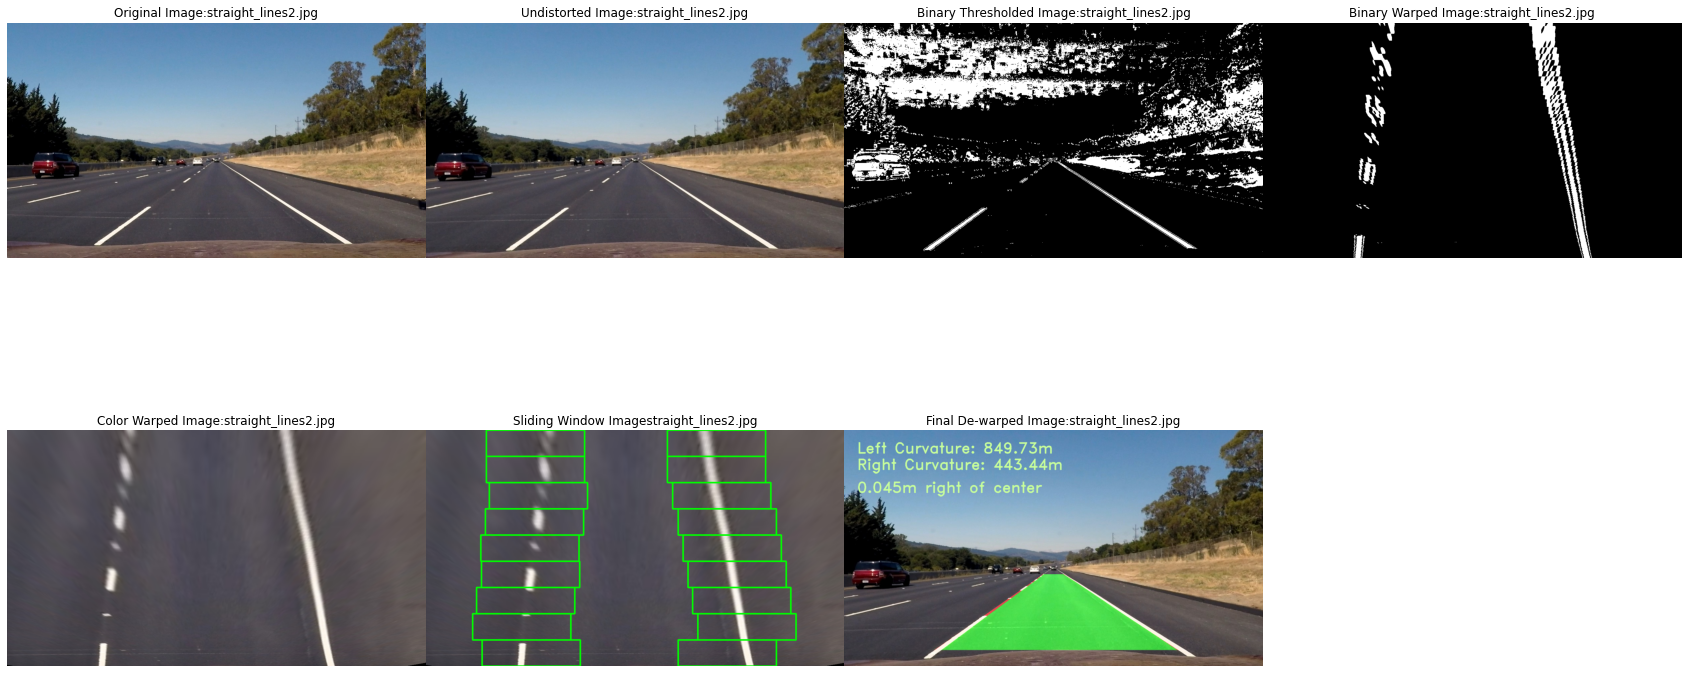

test5.jpg


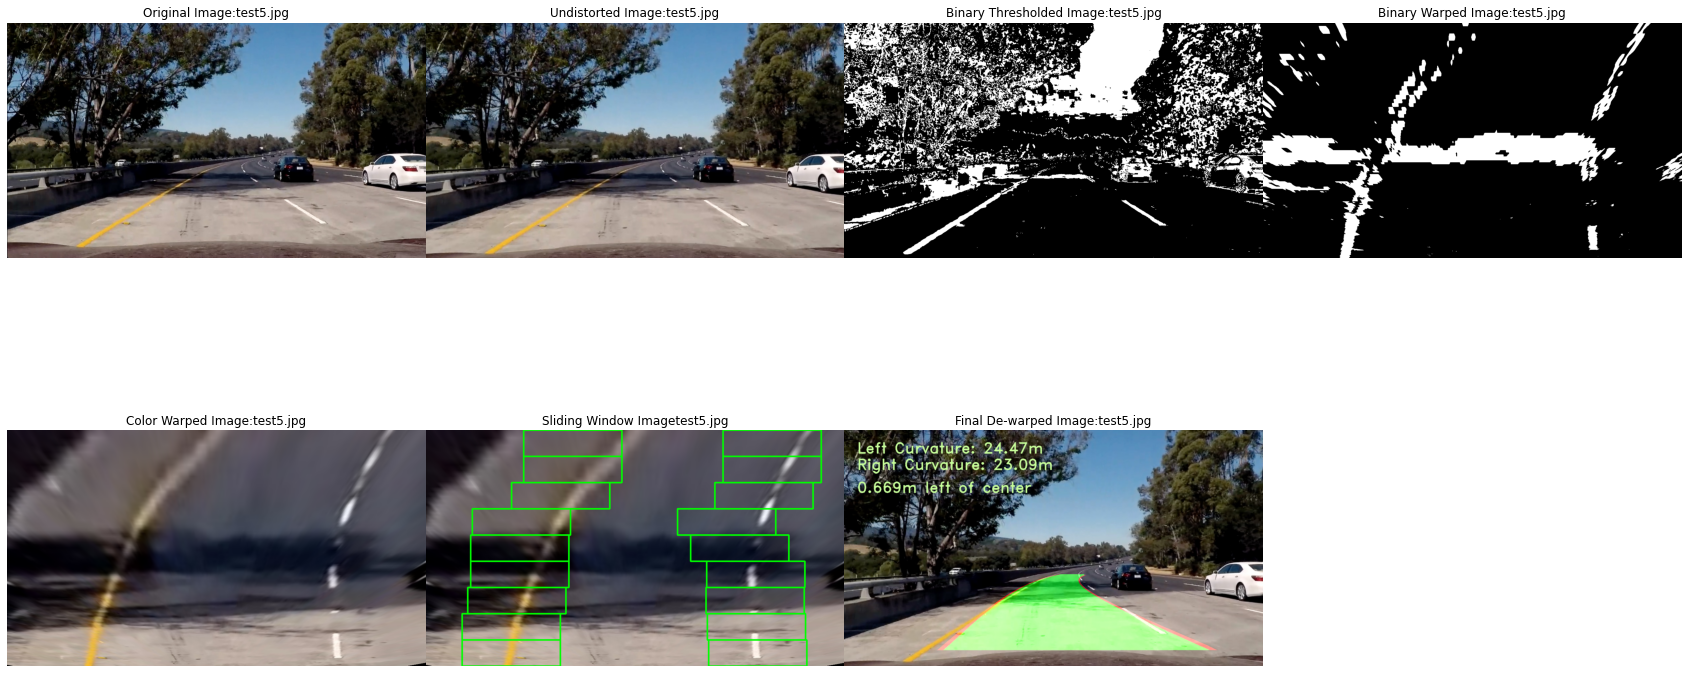

test1.jpg


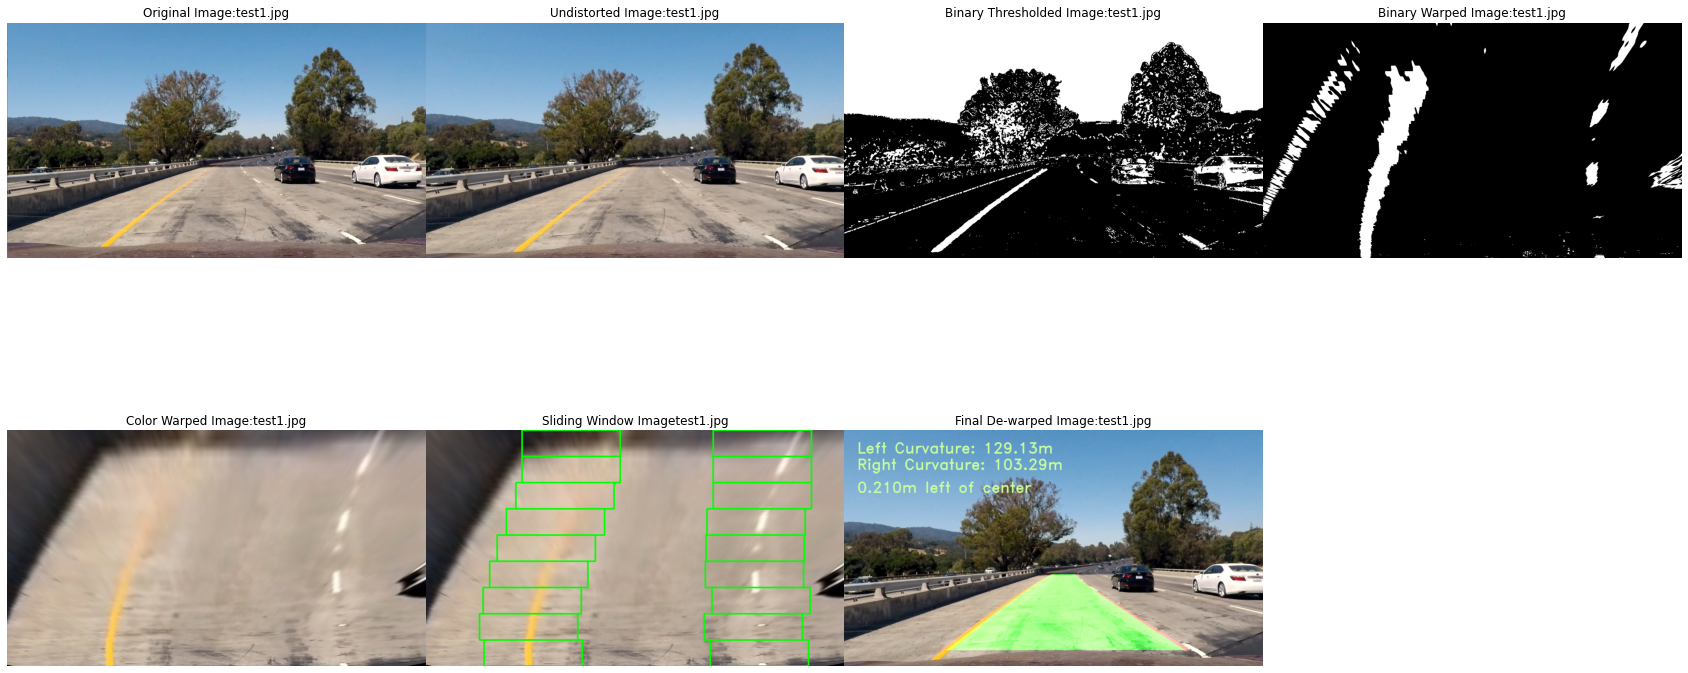

In [76]:
if __name__ == "__main__":
    main()

[MoviePy] >>>> Building video /content/output_images/project_video.mp4
[MoviePy] Writing video /content/output_images/project_video.mp4


100%|█████████▉| 1260/1261 [04:55<00:00,  4.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/output_images/project_video.mp4 



In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_images/project_video.mp4'))